## **Current optimization**
---
**Author**: Arent Kievits

#### Overview
- Find the optimal beam current for optical STEM by comparing the SNR at different dwell times. 
- Compare results

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cycler
from matplotlib.ticker import MultipleLocator
import matplotlib as mpl

from pathlib import Path
from skimage import img_as_float
import tifffile as tf
import pandas as pd
import altair as alt
from tqdm.notebook import tqdm

# Local imports
import sys
# Add code directory to path
code_dir = '../code/'
if code_dir not in sys.path:
    sys.path.insert(1, code_dir)
import ssnr

# config
%config Completer.use_jedi = False
pd.set_option("display.max_rows", None)

## 1. Load all image data
---

In [2]:
# Find directory
DATA_dir = Path("../data/5_Current-SNR-relation")

# Select files and initialize DataFrame with image locations
df_im = pd.DataFrame({'FilePos': list(DATA_dir.glob('0*/*.tif'))})

# Build up DataFrame
df_im['Current'] =  df_im['FilePos'].apply(lambda x: x.parents[0].name.split('nA')[0])#.split('_')[1])
df_im['Dwell'] =  df_im['FilePos'].apply(lambda x: x.name.split('_')[2].split('ns')[0])

# List values in ascending order
df_im['Dwell'] = df_im['Dwell'].astype(float)
df_im['Current'] = df_im['Current'].astype(float)
df_im = df_im.sort_values(['Dwell'], ascending=[True])

# Preview
df_im.sample(5)

,FilePos,Current,Dwell
134,..\data\5_Current-SNR-relation\0.4nA\OSTEM_4kV...,0.4,100.0
41,..\data\5_Current-SNR-relation\0.1nA\OSTEM_4kV...,0.1,10000.0
77,..\data\5_Current-SNR-relation\0.1nA\OSTEM_4kV...,0.1,500.0
61,..\data\5_Current-SNR-relation\0.1nA\OSTEM_4kV...,0.1,3000.0
109,..\data\5_Current-SNR-relation\0.2nA\OSTEM_4kV...,0.2,300.0


## 2. Perform SSNR measurements
---

In [6]:
# Initialize DataFrame for SNR
df_snr = pd.DataFrame(columns=['Current','Dwell time', 'SSNR'])

# Loop through bioimages
for i, row in tqdm(df_im.iterrows(), total=len(df_im)):

    # Load and crop images
    image = img_as_float(tf.imread(row['FilePos'].as_posix()))
    cropped = image[0:920,::]
        
    # Compute SNR from SSNR
    images = ssnr.split_image_rows(cropped) # Split into rows to avoid streaking effect
    snr = ssnr.SSNR_full(images)

    # Populate DataFrame
    df_snr.loc[i, 'Current'] = row['Current']
    df_snr.loc[i, 'Dwell'] = row['Dwell']
    df_snr.loc[i, 'SSNR'] = snr

# Preview
df_snr = df_snr.infer_objects()
df_snr.groupby('Current')\
      .apply(lambda x: x[::len(df_snr)//10])

  0%|          | 0/199 [00:00<?, ?it/s]

Current  Dwell time      SSNR    Dwell
Current                                            
0.05    15      0.05         NaN  0.125029    100.0
        40      0.05         NaN  0.175942    500.0
        1       0.05         NaN  1.344512  10000.0
0.10    51      0.10         NaN  0.135070    100.0
        78      0.10         NaN  0.184052    500.0
        42      0.10         NaN  0.987419  10000.0
0.20    90      0.20         NaN  0.154464    100.0
        117     0.20         NaN  0.225345    500.0
        81      0.20         NaN  1.786853  10000.0
0.40    134     0.40         NaN  0.255391    100.0
        158     0.40         NaN  0.228288    500.0
        123     0.40         NaN  1.356110  10000.0
0.80    170     0.80         NaN  0.207782    100.0
        166     0.80         NaN  0.411840   1000.0
        160     0.80         NaN  1.980729  10000.0

## 3. Plot results
---

In [7]:
source = df_snr[df_snr['Dwell'] > 300]

# Group by respective current and dwell, then calculat mean SSNR, reset index to dwell time. 
df_current_mean = source.groupby(by=['Current','Dwell']).apply(lambda x: x.mean())\
                        .drop(['Dwell','Current'], axis=1).reset_index(level='Dwell')
df_current_std = source.groupby(by=['Current','Dwell']).apply(lambda x: x.std())\
                        .drop(['Dwell','Current'], axis=1).reset_index(level='Dwell')
df_dwell_mean = source.groupby(by=['Dwell','Current']).apply(lambda x: x.mean())\
                        .drop(['Dwell'], axis=1)#.reset_index(level='Current (nA)')
df_dwell_std = source.groupby(by=['Dwell','Current']).apply(lambda x: x.std())\
                        .drop(['Dwell'], axis=1)#.reset_index(level='Current (nA)')

### Plot SSNR vs dwell time for different currents

0.05
0.1
0.2
0.4
0.8


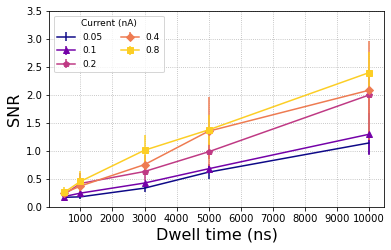

In [13]:
# Plot SSNR vs dwell time for different currents
fontsize = 16

# Colour
cmap = plt.get_cmap('plasma')
mpl.rcParams['axes.prop_cycle'] = cycler(color=cmap(np.linspace(0, 0.9, len(source['Current'].unique()))))
markers=["","^","p","D","s"]

# Make figure (Dwell time)
nrows = 1
ncols = 1
fig, ax = plt.subplots(ncols=ncols, nrows=nrows,
                         sharex=False, sharey=False,
                         figsize=(6*ncols, 3.6*nrows)) 
        
# Iterate through image subssets by coating:
for (current, current_mean), (current2, current_std), marker in zip(df_current_mean.groupby(by=['Current']), 
                                                                    df_current_std.groupby(by=['Current']),
                                                                    markers):
    
    ax.errorbar(current_mean['Dwell'], current_mean['SSNR'], current_std['SSNR'], marker=marker)   
   # ax.set_title(f"{current} nA", fontsize=fontsize)
    ax.grid(which='both', ls=':') 
    ax.set_ylabel('SNR', fontsize=fontsize)
    ax.set_xlabel('Dwell time (ns)', fontsize=fontsize)
    print(current)


ax.grid(which='both', ls=':') 
ax.set_ylabel('SNR', fontsize=fontsize)
ax.set_xlabel('Dwell time (ns)', fontsize=fontsize)   
ax.set_ylim([0, 3.5])
ax.legend(sorted(source['Current'].unique()), fontsize=fontsize-7, title="Current (nA)", title_fontsize=fontsize-7, ncol=2, loc='upper left') 
ax.xaxis.set_major_locator(MultipleLocator(1000))
# plt.savefig('SNR_vs_dwell', dpi=300, bbox_inches='tight')

### Plot SSNR vs current for different dwells

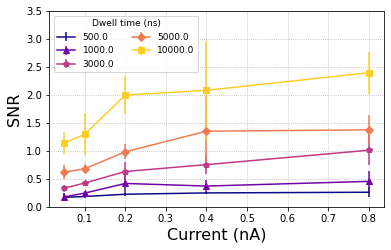

In [14]:
# Plot SSNR vs dwell time for different currents
fontsize = 16

# Colour
cmap = plt.get_cmap('plasma')
mpl.rcParams['axes.prop_cycle'] = cycler(color=cmap(np.linspace(0, 0.9, len(source['Dwell'].unique()))))
marker=["","^","p","D","s"]

# Make figure (Dwell time)
nrows = 1
ncols = 1
fig, ax = plt.subplots(ncols=ncols, nrows=nrows,
                         sharex=False, sharey=False,
                         figsize=(6*ncols, 3.6*nrows)) 
        
# Iterate through image subssets by coating:
for (dwell, dwell_mean), (dwell, dwell_std), marker in zip(df_dwell_mean.groupby(by=['Dwell']), 
                                                           df_dwell_std.groupby(by=['Dwell']),
                                                           marker):
    
    ax.errorbar(dwell_mean['Current'], dwell_mean['SSNR'], dwell_std['SSNR'], marker=marker)   
   # ax.set_title(f"{current} nA", fontsize=fontsize)

ax.grid(which='both', ls=':') 
ax.set_ylabel('SNR', fontsize=fontsize)
ax.set_xlabel('Current (nA)', fontsize=fontsize)   
ax.set_ylim([0, 3.5])
ax.legend(sorted(source['Dwell'].unique()), title="Dwell time (ns)", fontsize=fontsize-7, title_fontsize=fontsize-7, ncol=2, loc='upper left') 
# plt.savefig('SNR_vs_current.png', dpi=300, bbox_inches='tight')

## 5. Plot images with varying current
---

In [15]:
# Find directory
DATA_dir = Path("../data/5_Current-SNR-relation/Qualitative/Current")

# Select files and initialize DataFrame with image locations
df_im2 = pd.DataFrame({'FilePos': list(DATA_dir.glob('*.tif'))})

# Build up DataFrame
df_im2['Current (nA)'] =  df_im2['FilePos'].apply(lambda x: x.name.split('_')[2].split('nA')[0])
df_im2['DWELL TIME (ns)'] =  df_im2['FilePos'].apply(lambda x: x.name.split('_')[3].split('ns')[0])

# List values in ascending order
df_im2['Current (nA)'] = df_im2['Current (nA)'].astype(float)
df_im2.sort_values(['Current (nA)'], ascending=[True], inplace=True)

# Preview
df_im2

,FilePos,Current (nA),DWELL TIME (ns)
0,..\data\5_Current-SNR-relation\Qualitative\Cur...,0.05,10000
1,..\data\5_Current-SNR-relation\Qualitative\Cur...,0.10,10000
2,..\data\5_Current-SNR-relation\Qualitative\Cur...,0.20,10000
3,..\data\5_Current-SNR-relation\Qualitative\Cur...,0.40,10000
4,..\data\5_Current-SNR-relation\Qualitative\Cur...,0.80,10000


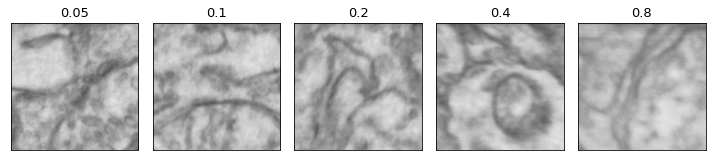

In [16]:
source = df_im2

# Make figure (Dwell time)
nrows = 1
ncols = df_im2['Current (nA)'].unique().size

fig, axes = plt.subplots(ncols=ncols, nrows=nrows,
                         sharex=False, sharey=True,
                         figsize=(2*ncols, 2.5*nrows))
axmap = {k: v for k, v in zip(source.index, axes)}
plt.subplots_adjust(hspace=0.06,
                    wspace=0.06)

for i, row in source.iterrows():
    im = img_as_float(tf.imread(row['FilePos'].as_posix()))
    cropped = im[:920,:920]
    axmap[i].imshow(cropped, cmap='Greys_r')
    title = f"{row['Current (nA)']}"
    axmap[i].get_xaxis().set_visible(False)
    axmap[i].set_yticks([], [])
        
    # Axis aesthetics
    axmap[i].set_title(title, fontsize=13)
plt.tight_layout()
# plt.savefig('current_comparison', dpi=300)

## 6. Plot images with varying dwell time
---

In [12]:
# Find directory
DATA_dir = Path("../data/Current_Optimization/Qualitative/Dwell")

# Select files and initialize DataFrame with image locations
df_im2 = pd.DataFrame({'FilePos': list(DATA_dir.glob('*.tif'))})

# Build up DataFrame
df_im2['Dwell'] =  df_im2['FilePos'].apply(lambda x: x.name.split('_')[2].split('ns')[0])

# List values in ascending order
df_im2['Current'] = 0.8 # nA
df_im2['Dwell'] = df_im2['Dwell'].astype(float)
df_im2.sort_values(['Dwell'], ascending=[True], inplace=True)

# Preview
df_im2

,FilePos,Dwell,Current
2,..\data\Current_Optimization\Qualitative\Dwell...,100.0,0.8
4,..\data\Current_Optimization\Qualitative\Dwell...,300.0,0.8
1,..\data\Current_Optimization\Qualitative\Dwell...,1000.0,0.8
3,..\data\Current_Optimization\Qualitative\Dwell...,3000.0,0.8
0,..\data\Current_Optimization\Qualitative\Dwell...,10000.0,0.8


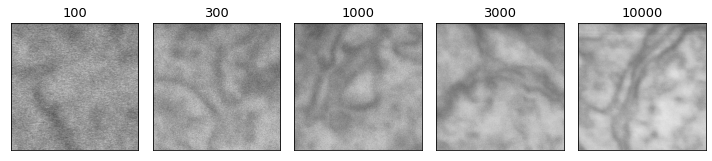

In [14]:
source = df_im2

# Make figure (Dwell time)
nrows = 1
ncols = df_im2['Dwell'].unique().size

fig, axes = plt.subplots(ncols=ncols, nrows=nrows,
                         sharex=False, sharey=True,
                         figsize=(2*ncols, 2.5*nrows))
axmap = {k: v for k, v in zip(source.index, axes)}
plt.subplots_adjust(hspace=0.06,
                    wspace=0.06)

for i, row in source.iterrows():
    im = img_as_float(tf.imread(row['FilePos'].as_posix()))
    cropped = im[:920,:920]
    axmap[i].imshow(cropped, cmap='Greys_r')
    title = f"{int(row['Dwell'])}"
    axmap[i].get_xaxis().set_visible(False)
    axmap[i].set_yticks([], [])
        
    # Axis aesthetics
    axmap[i].set_title(title, fontsize=13)
plt.tight_layout()
plt.savefig('dwell_comparison', dpi=300)